In [145]:
%load_ext autoreload
%autoreload 2

import numpy as np

import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import genfromtxt

%matplotlib inline

from controllers import DDeePC
plt.rcParams["figure.figsize"] = (15,10)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of controllers failed: Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    if update_generic(old_obj, new_obj):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/extensions/aut

In [146]:
ud = genfromtxt('recht_ud.csv', delimiter=',')
yd = genfromtxt('recht_yd.csv', delimiter=',')

In [147]:
n = 3 # n = number of states
m = 3 # m = number of inputs
p = 3 # p = number of output
q = m+p # q = number of i/o variables

Tini = 4                                   # Past time horizon                                           
Tf = 10                                     # Future time horizon         
T = (m+1)*(Tini + Tf + n) - 1    
noise_std = 0.1              

A = torch.Tensor([[1.01, 0.01, 0.00], # A - State-space matrix
                  [0.01, 1.01, 0.01], 
                  [0.00, 0.01, 1.01]])

In [148]:
yd += np.random.rand(T,p)*noise_std
u_ini = ud[:Tini,:].reshape((Tini*m,))
y_ini = yd[:Tini,:].reshape((Tini*p,))
y_constraints = np.kron(np.ones(Tf), np.array([100,100,100]))
u_constraints = np.kron(np.ones(Tf), np.array([100,100,100]))

## Imitation Learning

In [149]:
q = torch.ones(3)*100
r = torch.ones(3)*0.02
lam_y = torch.Tensor([0.2])

expert = DDeePC(
    ud=ud, yd=yd, N=Tf, Tini=Tini, T=T, p=3, m=3, n_batch=1,
    y_constraints=y_constraints, u_constraints=u_constraints,
    stochastic=True, linear=True, q=q, r=r, lam_y=lam_y
)

learner = DDeePC(
    ud=ud, yd=yd, N=Tf, Tini=Tini, T=T, p=3, m=3, n_batch=1,
    y_constraints=y_constraints, u_constraints=u_constraints,
    stochastic=True, linear=True, r=r
)

for param in learner.parameters():
    print(param)

Parameter containing:
tensor([6.5462, 9.5303, 8.6280], requires_grad=True)
Parameter containing:
tensor([9.3828], requires_grad=True)


## Performance

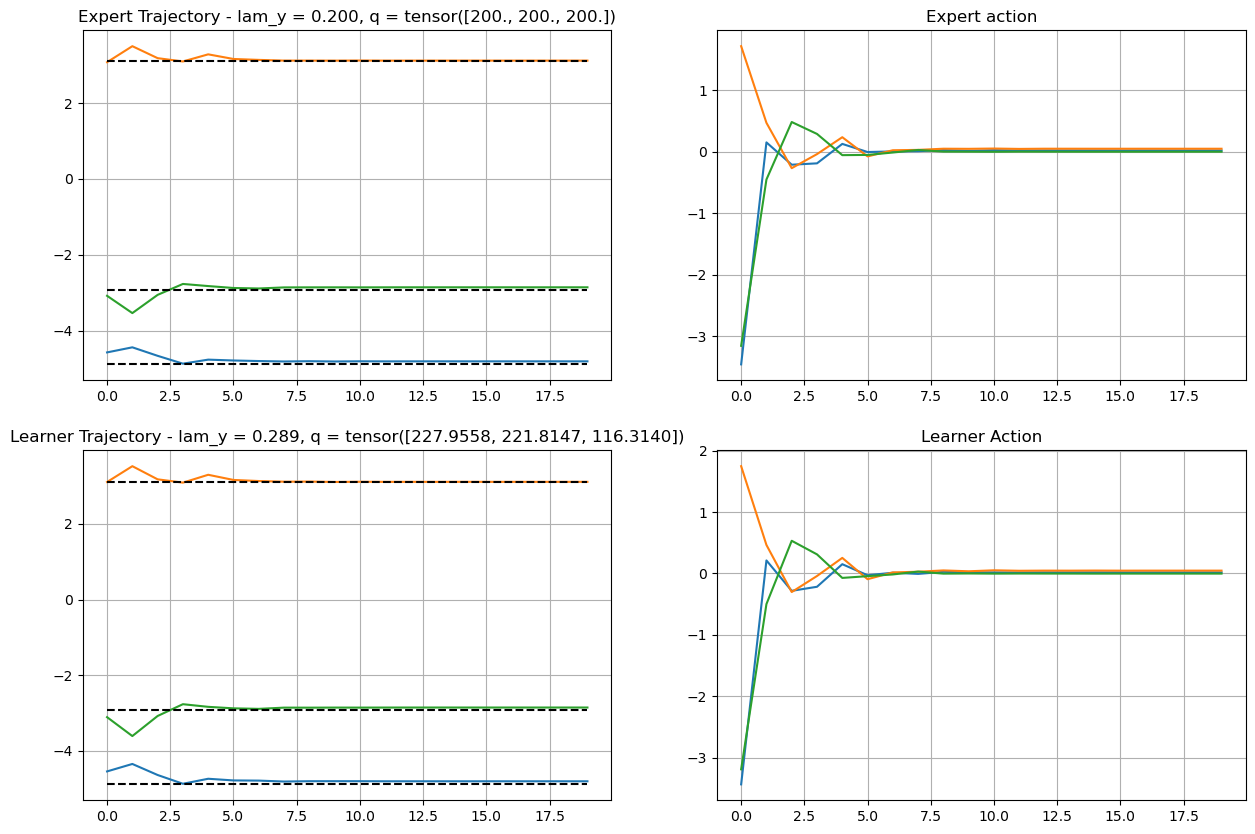

In [159]:
# Random reference
test_ref = torch.Tensor(np.random.uniform(size=(3,), low=-5.0, high=5.0))
# test_ref = torch.Tensor([3,0,-3])
test_ref = torch.kron(torch.ones(Tf), test_ref)

# Random initial condition
index = int(np.random.uniform(low=0, high=5))
learner_u_ini, learner_y_ini = ud[index:Tini + index, :].reshape((Tini*m,)), yd[index:Tini + index].reshape((Tini*p,))
expert_u_ini, expert_y_ini = learner_u_ini, learner_y_ini

T = 20
learner_u, learner_y = [*learner_u_ini], [*learner_y_ini]
expert_u, expert_y = [*expert_u_ini], [*expert_y_ini]

for i in range(T):
    # Solve for optimal actions
    u_pred, y_pred , _ = learner(ref=test_ref, u_ini=torch.Tensor(learner_u_ini), y_ini=torch.Tensor(learner_y_ini))
    u, y, _ = expert(ref=test_ref, u_ini=torch.Tensor(expert_u_ini), y_ini=torch.Tensor(expert_y_ini))

    # Roll sim forward
    learner_action, expert_action = u_pred[:p], u[:p]
    learner_obs = A@learner_y_ini[-p:] + learner_action #+ noise 
    expert_obs = A@expert_y_ini[-p:] + expert_action #+ noise

    # Collect data
    learner_u, learner_y = np.append(learner_u, learner_action.detach().numpy()), np.append(learner_y, learner_obs.detach().numpy())
    expert_u, expert_y = np.append(expert_u, expert_action.detach().numpy()), np.append(expert_y, expert_obs.detach().numpy())
    learner_u_ini, learner_y_ini = learner_u[-m*Tini:], learner_y[-p*Tini:]
    expert_u_ini, expert_y_ini = expert_u[-m*Tini:], expert_y[-p*Tini:]
    

learner_y = learner_y[p*Tini:].reshape((T, 3))
expert_y = expert_y[p*Tini:].reshape((T, 3))
learner_u = learner_u[p*Tini:].reshape((T, 3))
expert_u = expert_u[p*Tini:].reshape((T, 3))
# test_ref = test_ref.detach().numpy().reshape((Tf, 3))
test_ref = np.kron(np.ones(T), test_ref[:p].detach().numpy()).reshape((T,3))

plt.subplot(2,2,1)
plt.title(f'Expert Trajectory - lam_y = {expert.lam_y.item():.3f}, q = {expert.q}')
plt.grid('on')
plt.plot(range(T), expert_y)
plt.plot(range(T), test_ref, 'k--')
plt.subplot(2,2,2)
plt.title(f'Expert action')
plt.grid('on')
plt.plot(range(T), expert_u)
plt.subplot(2,2,3)
plt.title(f'Learner Trajectory - lam_y = {learner.lam_y.item():.3f}, q = {learner.q.data}')
plt.grid('on')
plt.plot(range(T), learner_y)
plt.plot(range(T), test_ref, 'k--')
plt.subplot(2,2,4)
plt.title(f'Learner Action')
plt.grid('on')
plt.plot(range(T), learner_u)
plt.show()

## Training

In [151]:
opt = optim.RMSprop(learner.parameters(), lr=0.1)
pbar = tqdm(range(5000), ncols=150)
criterion = torch.nn.MSELoss()
# scheduler = lr_scheduler.LinearLR(opt, start_factor=1.0, end_factor=0.01, total_iters=1000)

for i, count in enumerate(pbar):
    # Get random step response
    ref = torch.Tensor(np.random.uniform(size=(3,), low=-10.0, high=10.0))
    ref = torch.kron(torch.ones(Tf), ref)
    
    # Get random initial condition from data
    index = int(np.random.uniform(low=0, high=5))
    u_ini, y_ini = torch.Tensor(ud[index:Tini + index, :].reshape((Tini*m,))), torch.Tensor(yd[index:Tini + index].reshape((Tini*p,)))
    uT, yT = u_ini, y_ini
    
    for j in range(Tf):
        # Get optimal action from controller, take MSE of trajectory and reference signal
        try:
            u_pred, y_pred , cost = learner(ref=ref, u_ini=u_ini, y_ini=y_ini)
        except AssertionError:
            u_pred, y_pred , cost = learner(ref=ref, u_ini=u_ini, y_ini=y_ini)

        action = u_pred[:m]
        obs = A@y_ini[-p:] + action
        uT, yT = torch.cat((uT, action), 0), torch.cat((yT, obs), 0)
        y_ini, u_ini = yT[-p*Tini:], uT[-m*Tini:]

    loss = criterion(input=yT[p*Tini:], target=ref)
    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()
    # scheduler.step()
    
    pbar.set_description(f'Loss = {loss.item():.10f}, lam_y = {learner.lam_y.data.item():.9f}, q = {learner.q.data}')

Loss = 0.0183081552, lam_y = 0.289375067, q = tensor([227.9558, 221.8147, 116.3140]): 100%|███████████████████████| 5000/5000 [27:13<00:00,  3.06it/s]
